# Preparing a simple FNN 

In [1]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


from pathlib import Path
import numpy as np



2025-08-04 15:31:24.655078: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-04 15:31:24.672037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754335884.687018  467990 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754335884.691101  467990 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754335884.706356  467990 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Data Processing
1. Import data and collate them as numpy array

In [51]:
data_dir = Path('./water_energies_noise')
X = []
Y = []
for file_path in data_dir.glob('*.npz'):
    data_file = np.load(file_path)
    try:
        X.append(data_file['coords'])
        Y.append(data_file['energy'])
    except KeyError:
        raise KeyError('wrong key for npz file!')
    
X = np.stack(X)
Y = np.stack(Y)
print(X.shape)
print(Y.shape)

(1000, 3, 3)
(1000,)


2. split them and prepare them as tf input

In [52]:
x_train, x_valtest, y_train, y_valtest = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size=0.33, random_state=42)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(700, 3, 3) (700,)
(201, 3, 3) (201,)
(99, 3, 3) (99,)


3. Prepare dataset, batching and shuffle

In [53]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset =tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 32

train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

## Define model

In [101]:
def train(train_dataset, val_dataset, epochs=1000):
    '''
    Simple model:
    1. Input: flatten
    2. Hidden: 1 Dense layer, shape = 64, relu activation
    3. Output: Dense
    '''
    # 
    # model = tf.keras.Sequential([
    #     tf.keras.layers.Flatten(input_shape=(3,3)),
    #     tf.keras.layers.Dense(64, activation='relu'),
    #     tf.keras.layers.Dense(1)
    # ])
    y_mean = y_train.mean() 
    Initializer = tf.keras.initializers.Constant(y_mean)
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((3, 3, 1), input_shape=(3, 3)),      # Add channel dim
        tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),       # 32 filters, 2x2 kernel
        # tf.keras.layers.MaxPooling2D(strides=2),
        tf.keras.layers.Flatten(),                                   # Flatten for Dense
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, bias_initializer=Initializer)                                     # Regression output
    ])
    # model = tf.keras.Sequential([
    #     # 1) Keep your reshape
    #     tf.keras.layers.Reshape((3, 3, 1), input_shape=(3, 3)),

    #     # 2) First conv block
    #     tf.keras.layers.Conv2D(32, (2, 2), activation='relu', padding='same'),
    #     tf.keras.layers.BatchNormalization(),           # normalize feature maps
    #     tf.keras.layers.Dropout(0.1),                   # small dropout

    #     # 3) Second conv block
    #     tf.keras.layers.Conv2D(64, (2, 2), activation='relu', padding='same'),
    #     tf.keras.layers.BatchNormalization(),
    #     # No pooling—our “image” is tiny, so we just let GlobalAvgPool handle it

    #     # 4) Global pooling instead of flatten
    #     tf.keras.layers.GlobalAveragePooling2D(),        

    #     # 5) Dense head
    #     tf.keras.layers.Dense(64, activation='relu'),
    #     tf.keras.layers.Dropout(0.2),

    #     # 6) Final regression output
    #     tf.keras.layers.Dense(1)
    # ])
    model.compile(optimizer='adam', loss='mse')

    
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, verbose=0)
    return model, history.history

## Training

In [102]:
model, history = train(train_dataset, val_dataset, epochs=1000)

/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Plot loss curve

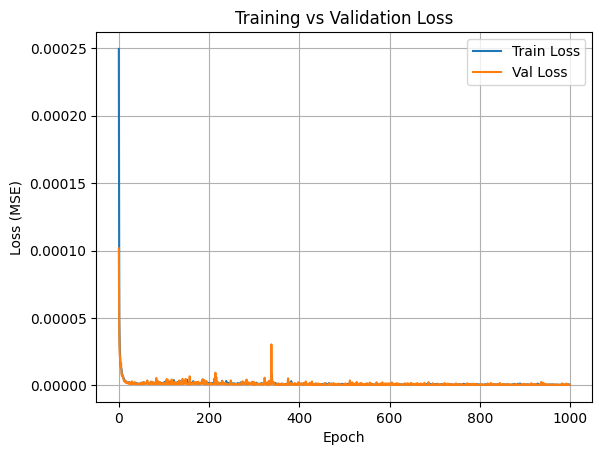

In [103]:
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

In [104]:
test_loss = model.evaluate(test_dataset)
print(f"Test MSE loss: {test_loss:.5f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3404e-07
Test MSE loss: 0.00000


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


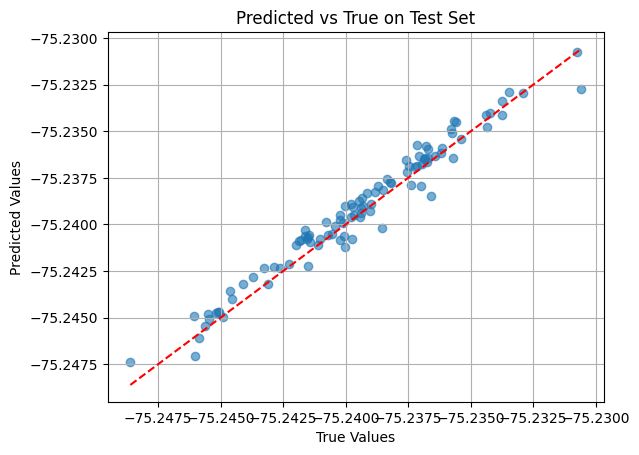

In [105]:
y_pred = model.predict(test_dataset).flatten()
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # perfect prediction line
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True on Test Set")
plt.grid(True)
plt.show()

You can see CNN is much much much better than FNN. GNN also fails (or maybe I didnt set up correctly)

## Build a simple GNN
Yep everything is kinda copies from ChatGPT...

1. Re-preprocess X, Y (numpy arrays) into graph data with specktral

In [ ]:
import numpy as np
import tensorflow as tf

from spektral.data import Dataset, Graph
from spektral.data.loaders import DisjointLoader


def build_adjacency_from_xyz(coords, threshold=2.0):
    """
    Given coords: (n_atoms, 3), returns (n_atoms, n_atoms) adjacency matrix
    with 1s where Euclidean distance < threshold and 0 elsewhere (excluding self-loops)
    """
    n = coords.shape[0]
    dists = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=-1)
    A = (dists < threshold).astype('float32')
    np.fill_diagonal(A, 0.0)  # remove self-loops
    return A

class XYZGraphDataset(Dataset):
    def __init__(self, X, Y, threshold=2.0, **kwargs):
        self.X = X.astype('float32')         # (N, n_atoms, 3)
        self.Y = Y.astype('float32')         # (N,)
        self.threshold = threshold
        super().__init__(**kwargs)

    def read(self):
        graphs = []
        for x, y in zip(self.X, self.Y):
            A = build_adjacency_from_xyz(x, threshold=self.threshold)  # shape (n_atoms, n_atoms)
            graphs.append(Graph(x=x, a=A, y=np.array([y])))
        return graphs

In [38]:
from spektral.layers import GraphSageConv, GlobalSumPool

class GNNModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = GraphSageConv(64, activation='relu')
        self.conv2 = GraphSageConv(64, activation='relu')
        self.pool = GlobalSumPool()
        self.dense = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x, a, i = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.pool([x, i])
        return self.dense(x)



2. Define model

In [45]:
def train_GNN(x_train, y_train,
              x_val, y_val, 
              epochs=10, batch_size=32, threshold=2.0):
    # Create dataset
    train_dataset = XYZGraphDataset(x_train, y_train, threshold=threshold)
    train_loader = DisjointLoader(train_dataset, epochs=epochs, batch_size=batch_size, shuffle=True)

    val_dataset = XYZGraphDataset(x_val, y_val, threshold=threshold)
    val_loader = DisjointLoader(val_dataset, epochs=epochs, batch_size=batch_size, shuffle=False)
    
    # Build and compile model
    with tf.device('/CPU:0'):
        model = GNNModel()
        model.compile(optimizer='adam', loss='mse')

        # Train
        history = model.fit(train_loader.load(), steps_per_epoch=train_loader.steps_per_epoch, 
                            validation_data=val_loader.load(), validation_steps=val_loader.steps_per_epoch,
                            epochs=epochs)    
    
    return model, history.history


3. Train

In [46]:
model, history = train_GNN(x_train=x_train,y_train=y_train,
                           x_val=x_val,y_val=y_val,
                           epochs=200)


Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5419.6538 - val_loss: 5233.1963
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5161.4858 - val_loss: 5103.6235
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5072.2778 - val_loss: 5039.9810
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5012.5845 - val_loss: 4982.8545
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4956.3281 - val_loss: 4927.0615
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4900.4854 - val_loss: 4871.0044
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4844.1270 - val_loss: 4814.3428
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4787.2705 - val_loss: 4757.3281
Epoch 9/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4730.1914 - val_loss: 4700.2056
Epoch 10/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4673.0801 - val_loss: 4643.1152
Epoch 11/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4616.0352 - val_loss: 4586.1

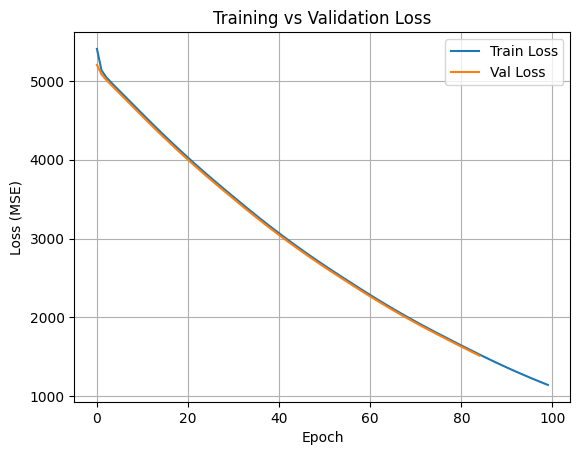

In [41]:
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
print(x_test.shape, y_test.shape)

(99, 3, 3) (99,)


In [48]:
# Create test dataset and loader
test_dataset = XYZGraphDataset(x_test, y_test, threshold=2.0)
test_loader = DisjointLoader(test_dataset, epochs=1, batch_size=32, shuffle=False)

# Evaluate on test set
test_loss = model.evaluate(test_loader.load(), steps=test_loader.steps_per_epoch)
print(f"Test MSE loss: {test_loss:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 57.1462 
Test MSE loss: 57.15


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/stepWARNING:tensorflow:5 out of the last 140 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7e9f9881fec0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
y_pred shape: (99,)


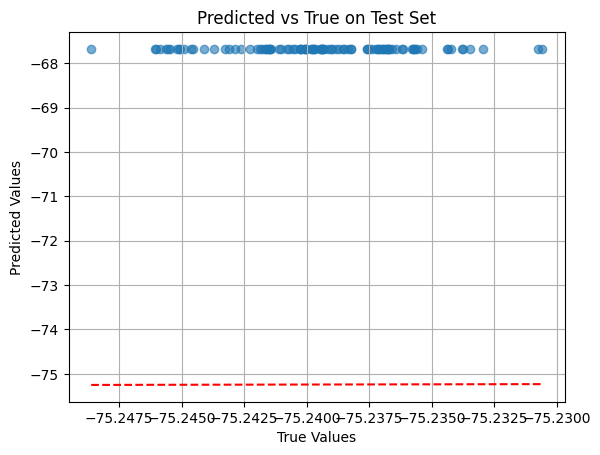

In [49]:
# CRITICAL: **Re‐instantiate** the loader for prediction
pred_loader = DisjointLoader(test_dataset, batch_size=32, epochs=1, shuffle=False)
y_pred = model.predict(pred_loader.load(), steps=pred_loader.steps_per_epoch).flatten()

# 3) Now y_pred.shape == y_true.shape == 99
print("y_pred shape:", y_pred.shape)

# 4) Plot
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True on Test Set")
plt.grid(True)
plt.show()

